In [1]:
import os
os.chdir('/home/pdavid/Bureau/Code/SS/2D_cartesian/SS_code')
import numpy as np 
import reconst_and_test_module as post
import matplotlib.pyplot as plt
import sys
sys.path.append('/non_neigh_orig')
import module_2D_coupling as orig 
import importlib
sys.path.append('/Neighbours')

plt.rcParams.update({'font.size': 20})


/home/pdavid/Bureau/Code/SS/2D_cartesian/SS_code/Neighbours


ModuleNotFoundError: No module named 'module_2D_coupling'

Properties of the sources and the problem

In [ ]:
#0-Set up the sources
Rv=0.01
C0=1
K_eff=1/(np.pi*Rv**2)
#pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[1.5,4.5]])-np.array([0.25,0.25])
pos_s=np.array([[3.5,3.8],[3.4,3.4], [4.1, 3.6],[3.85,3.85]])-np.array([0.25,0.25])
#1-Set up the domain
D=1
L=6
h_ss=1
x_ss=np.linspace(h_ss/2, L-h_ss/2, int(L//h_ss))
y_ss=x_ss

We obtain the full problem of the concentration field:
\begin{cases}
\Delta \phi(\mathbf{x}) = \sum_{j \in \Omega} q_j \delta_j(\mathbf{x},\mathbf{x}_j) \quad  in \quad \Omega\\
\\
  \phi(\mathbf{x})= 0 \quad  on \quad \partial \Omega \\
\end{cases}  
<br>
<br>
and,
<br>
$$q_j=K_{eff} \pi Rv_j^2 (\langle \phi_j \rangle - \bar{\phi}_j)$$
<br>
$$\bar{\phi}_j=\phi({x}_j)$$

For the assembly of the problem:  <br>
$\quad$ - First, we use the assembly of the laplacian that has been validated <br>
$\quad$ - Second, we translate the Dirichlet boundary conditions to Neuman

In [ ]:
A=orig.A_assembly(len(x_ss), len(y_ss))*D/h_ss**2
#set dirichlet
B,A=orig.set_TPFA_Dirichlet(0,A, h_ss, orig.get_boundary_vector(len(x_ss), len(y_ss)), np.zeros(len(x_ss)*len(y_ss)),D)

To model the sources interaction with the tissue we use the solution splitting technique:
Assemble of the problem
$$
M=
\begin{bmatrix}
[A] & [B] & [C]\\
[D] & [E] & [F]\\
[G] & [H] & [I]
\end{bmatrix} 
$$

For the steady state problem:
$$
M * \begin{Bmatrix}\phi \\ {v} \\ q\end{Bmatrix}= \begin{Bmatrix}0 \\ {0} \\ \langle \phi \rangle\end{Bmatrix}
$$

In [2]:
#Assemble of the solution split problem 
t=orig.assemble_SS_2D_FD(pos_s, A, Rv, h_ss,x_ss,y_ss, K_eff, D) #__init__ function
t.pos_arrays() #gets all the connectivity arrays that are necessary
t.assembly_sol_split_problem() #assembles all the submatrices and joins them into a big one

NameError: name 'orig' is not defined

In [3]:
np.where(np.unique(t.s_blocks)==21)[0][0]


NameError: name 't' is not defined

In [4]:
#initial right hand side
B_v=np.zeros(len(np.unique(t.s_blocks))*9)
B_q=np.ones(len(t.s_blocks))
#B_q[-2]=-1
B=np.concatenate((B,B_v,B_q))

phi=np.linalg.solve(t.M, B)


NameError: name 't' is not defined

In [5]:
phi_FV, phi_v, phi_q=post.separate_unk(t, phi)
phi_mat=phi_FV.reshape(len(x_ss), len(y_ss))

NameError: name 't' is not defined

In [6]:
o=post.reconst_microscopic(t, phi)    
rec=o.reconstruct(20,L)

NameError: name 't' is not defined

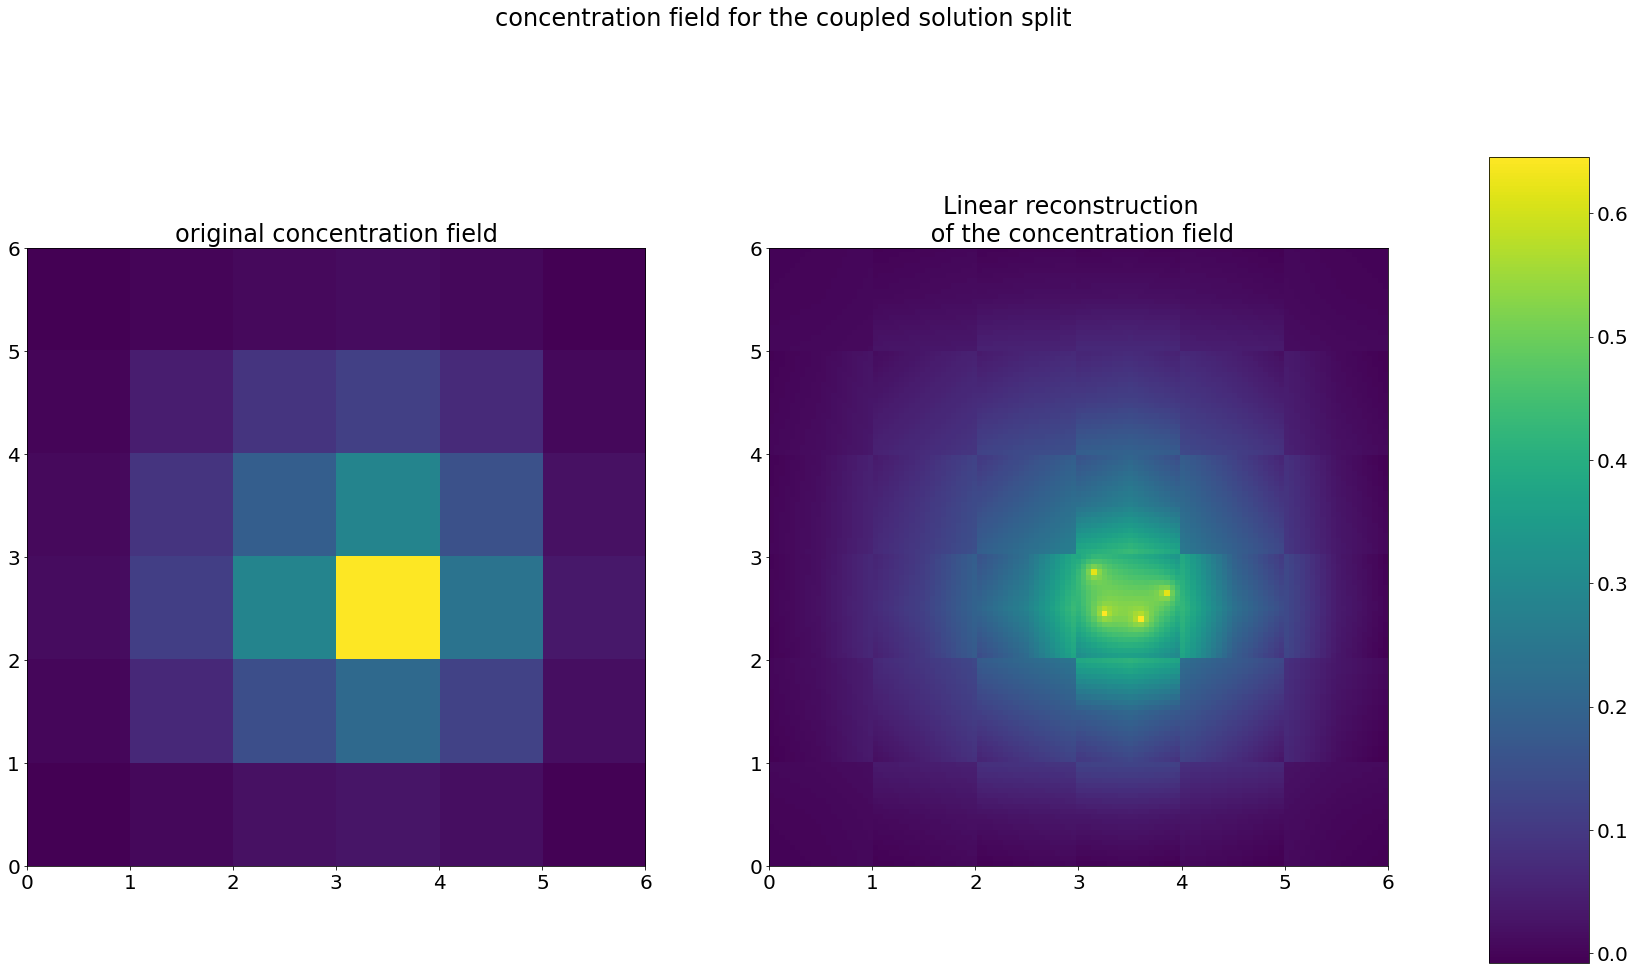

In [80]:
fig, axs=plt.subplots(1,2, figsize=(28,16))
fig.suptitle("concentration field for the coupled solution split")
im=axs[0].imshow(phi_FV.reshape(len(y_ss), len(x_ss)), extent=[0,L,0,L])
axs[0].set_title("original concentration field")
im=axs[1].imshow(rec, extent=[0,L,0,L])
axs[1].set_title("Linear reconstruction  \n of the concentration field")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

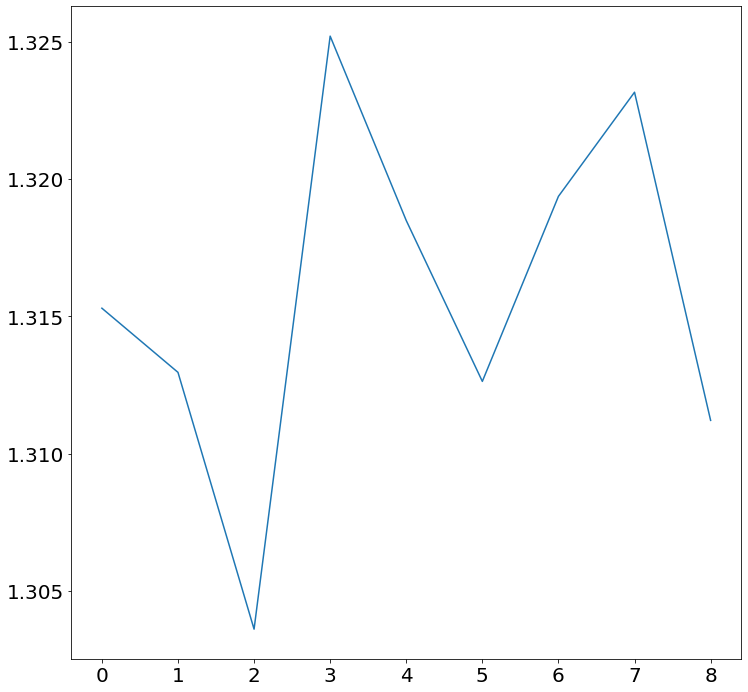

In [93]:
plt.plot(phi_v)

In [81]:
sol_val, xlen2, ylen2,q_array,a, Y, s_b,x_v,y_v=orig.get_validation(20, t, pos_s, B_q, D, K_eff, Rv,L)


In [82]:
val_mat=sol_val.reshape(ylen2, xlen2)

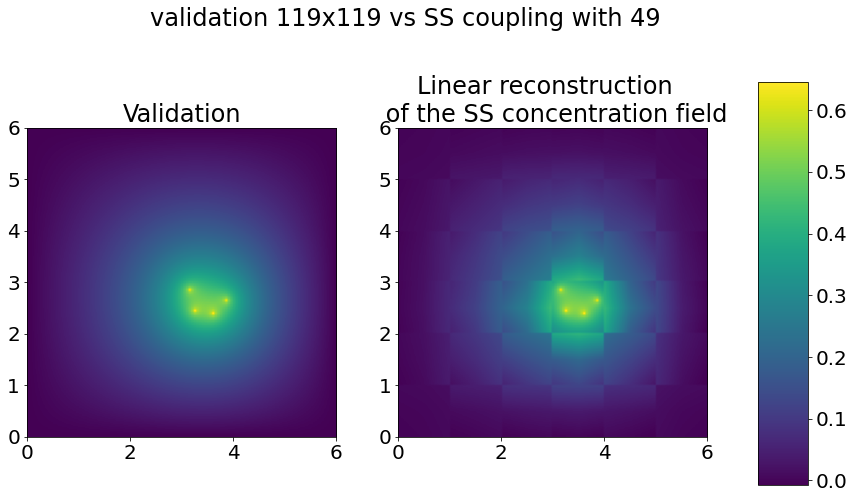

In [83]:
fig, axs=plt.subplots(1,2, figsize=(14,8))
title="validation {}x{} vs SS coupling with {}".format(xlen2, ylen2, t.M.shape[0])
fig.suptitle(title)
im=axs[0].imshow(sol_val.reshape(ylen2, xlen2), extent=[0,L,0,L])
axs[0].set_title("Validation")
im=axs[1].imshow(rec, extent=[0,L,0,L])
axs[1].set_title("Linear reconstruction  \n of the SS concentration field")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

Get the comparison plots 

Test the efficiency of the scheme

In [84]:
q_comp=np.zeros((0,len(q_array)))
solutions=[]
lx=np.array([])
x_c=[]
y_c=[]

for i in np.arange(4)+1:
    sol, xlen3, ylen3,q_array,a, Y, s_b,p,pp=orig.get_validation(i**2, t, pos_s, B_q, D, K_eff, Rv,L)
    q_comp=np.concatenate((q_comp, np.array([q_array])), axis=0)
    solutions.append(sol)
    lx=np.append(lx, xlen2)
    x_c.append(p)
    y_c.append(pp)

In [85]:
def get_plots_comp(pos_s, solution, rec, o, y_c,x_c, validation, y_v, x_v):
    solution=solution.reshape(len(y_c),len(x_c))
    val_mat=validation.reshape(len(y_v), len(x_v))
    row_rec=np.array([], dtype=int)
    for i in pos_s:
        row=np.argmin(np.abs(i[1]-o.y))
        row_rec=np.append(row_rec, row)
    print(row_rec)
    row_c=np.array([], dtype=int)
    for i in pos_s:
        row=np.argmin(np.abs(i[1]-y_c))
        row_c=np.append(row_c, row)
    row_v=np.array([], dtype=int)
    for i in pos_s:
        row=np.argmin(np.abs(i[1]-y_v))
        row_v=np.append(row_v, row)
    fig, axs=plt.subplots(2,2, figsize=(14,14))
    fig.suptitle("comparison SS vs {}x{} FV".format(len(y_c), len(x_c)))
    for i in range(2):
        for j in range(2):
            a=int(j+2*i)
            axs[i,j].plot(x_c, solution[row_c[a],:], label="FV")
            axs[i,j].plot(o.x, rec[row_rec[a],:], label="SS reconstructed")
            axs[i,j].plot(x_v, val_mat[row_v[a],:], label="validation") 
            axs[i,j].set_title("source={}".format(a))
            axs[i,j].legend(loc="lower center")
    plt.show()


0
[70 62 66 71]


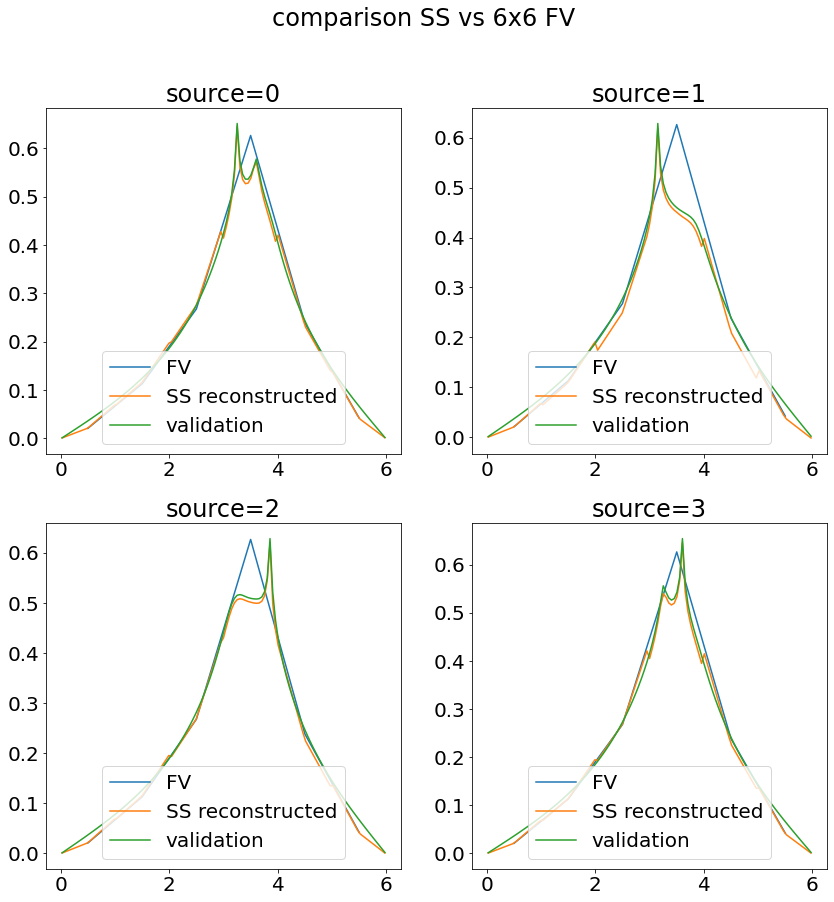

1
[70 62 66 71]


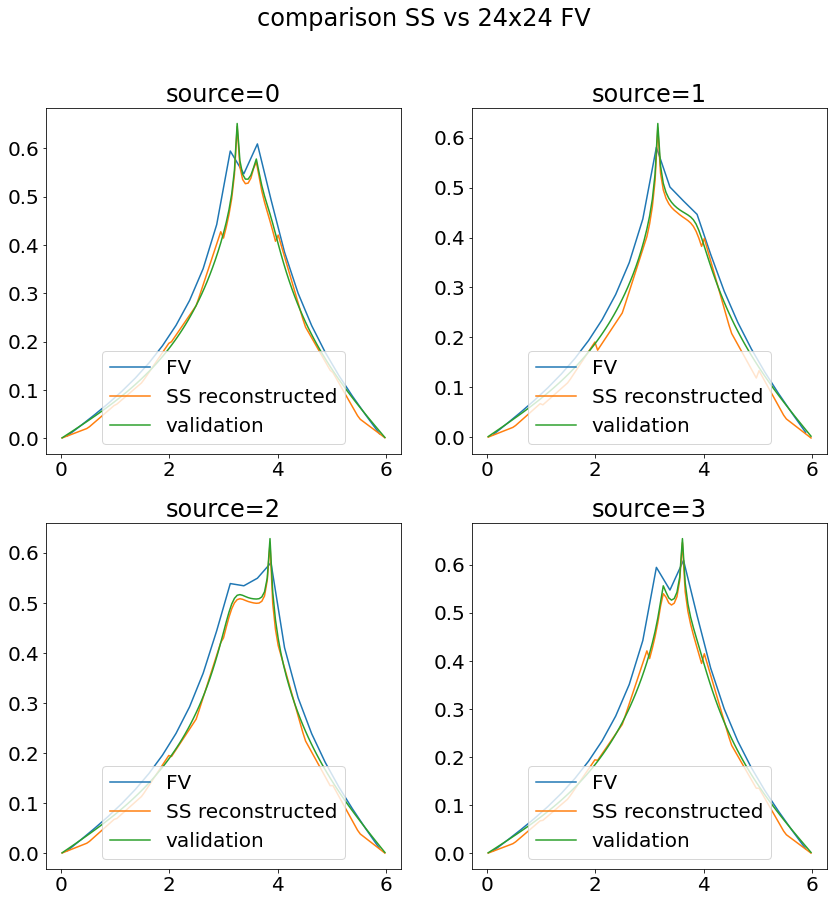

2
[70 62 66 71]


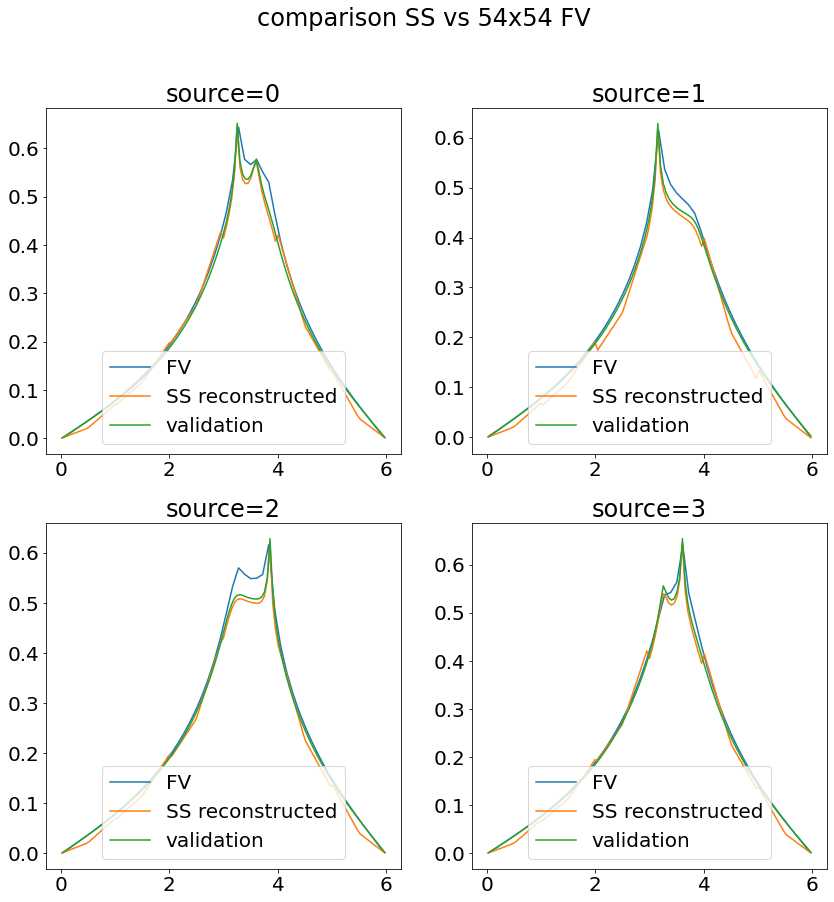

3
[70 62 66 71]


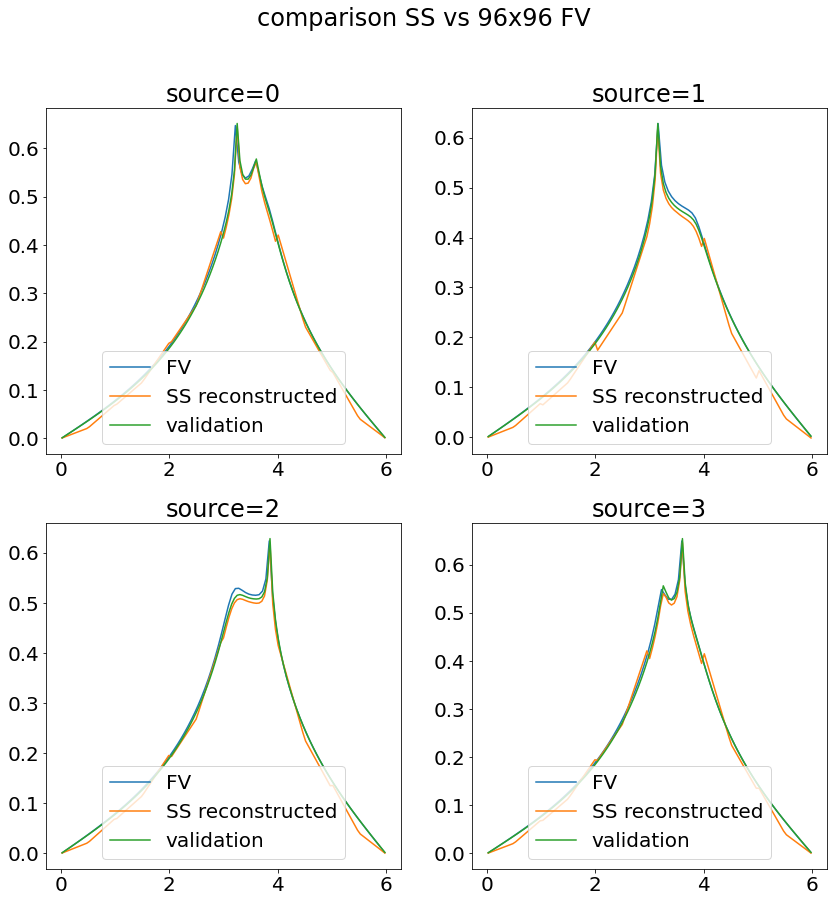

In [86]:
for a in np.arange(len(pos_s)):
    print(a)
    get_plots_comp(pos_s, solutions[a], rec, o, x_c[a], y_c[a], sol_val, y_v,x_v)

In [87]:
q_array

array([0.35306053, 0.37160318, 0.37656601, 0.35097948])

In [88]:
phi_q

array([0.35491714, 0.38082178, 0.37963269, 0.35247708])

Text(0, 0.5, 'relative error')

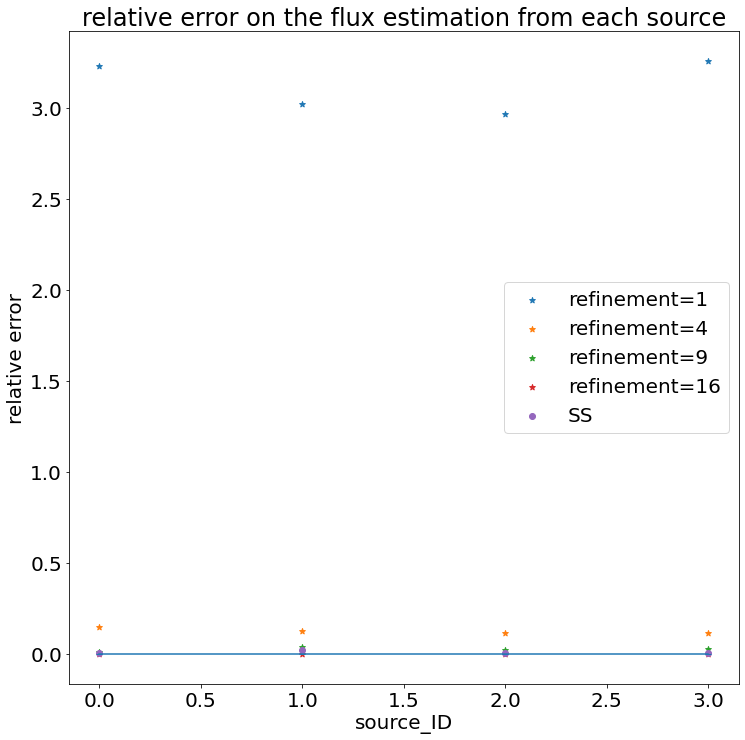

In [89]:
plt.rcParams["figure.figsize"] = (12,12)
for i in range(4):
    plt.scatter(np.arange(4),(q_comp[i]-q_array)/q_array, label="refinement={}".format((i+1)**2), marker='*')
plt.scatter(np.arange(4),(phi_q-q_array)/q_array, label="SS")
plt.plot(np.arange(4), np.zeros(4), marker="_")
plt.legend()
plt.title("relative error on the flux estimation from each source")
plt.xlabel("source_ID")
plt.ylabel("relative error")

In [90]:
post.manual_test_s_block_grads(t, phi,t.s_blocks[0])

The matrix calculated v_flux:  [ 0.0150074  -0.00104606  0.01652241 -0.00599211]
The manually calculated v_flux:  [ 0.0150074  -0.00104606  0.01652241 -0.00599211]
The matrix calculated G_flux:  [0.31339568 0.38212443 0.37530028 0.39702829]
The manually calculated G_flux:  [0.31339568 0.38212443 0.37530028 0.39702829]
The total calculated flux:  [0.32840308 0.38107837 0.39182269 0.39103618]
The total calculated flux:  [0.32840308 0.38107837 0.39182269 0.39103618]
div v 0.02449163530713161
total leaving flux 1.4923403259966261


array([-0.32840308, -0.38107837, -0.39182269, -0.39103618])

In [91]:
grads=post.reconstruction_gradients_manual(phi, t,get_boundary_vector(len(t.x), len(t.y)))
grads[t.s_blocks[0]]

NameError: name 'get_boundary_vector' is not defined

In [ ]:
q_array

In [ ]:
phi_q